In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from dotenv import load_dotenv
load_dotenv()
project_root = os.getenv("PROJECT_ROOT")
module_path = f"{project_root}/"
sys.path.insert(0, module_path)


In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pandas as pd
import torch
import torch.nn.functional as F

from matplotlib_venn import venn2
from tqdm import  tqdm
from torchvision import models, transforms
import multiprocessing




from utils import *
from classes import *
sns.set_palette(sns.color_palette("deep"))
pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [3]:



benign_root = f"{project_root}/datasets/final_datasets/benign/full_size"
adv_root = f"{project_root}/datasets/final_datasets/adversarial"

binary_load_root = f"{project_root}/weights/recovery/binary.pt"

sad_load_root = f"{project_root}/weights/recovery/spectral.pt"

In [4]:

dataset_batch_size=32

## Shuffles the datasets.
should_shuffle_datasets = True



## Needs to be scaled to support resnets dense layers, which require 224,224 image sizes
img_transforms = transforms.Compose([
    transforms.Lambda(lambda x:  F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False, antialias=True).squeeze(0)),
    ])

## Returns an array and map of the classification labels, i.e. "inanimate".
int_labels, label_map = get_label_arr_and_map(
    torch_features=3
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [5]:
mixed_data = gen_mixed_detection_tvt_dict(
        ben_root=benign_root,
        adv_root=adv_root,
        img_transforms=img_transforms,
        batch_size=dataset_batch_size,
        should_shuffle_datasets=True,
        should_truncate_datasets=True,
        should_return_class=True,
        should_return_attack_type=True,
        num_workers=multiprocessing.cpu_count()
    )

In [6]:
binary_detector = models.resnet101(weights=None)

binary_detector_weights = torch.load(
    f=f"{binary_load_root}"
    )

binary_detector.fc = torch.nn.Linear(in_features=2048, out_features=1)

binary_detector.load_state_dict(binary_detector_weights)

if torch.cuda.is_available():
    binary_detector = binary_detector.cuda()
    
binary_detector.eval()

print()

In [7]:
sad_detector = LogisticRegressionPL(3*224*224)



sad_detector_weights = torch.load(
    f=f"{sad_load_root}"
    )

sad_detector.load_state_dict(sad_detector_weights)

if torch.cuda.is_available():
    sad_detector = sad_detector.cuda()
    
sad_detector.eval()

print()

In [8]:
b_preds = []
s_preds = []

def normalize_ffts(batch_tensor, eps=1e-8):
    # Normalize the tensor after applying the Fourier transform
    

    batch_min = batch_tensor.min(dim=1, keepdim=True)[0]
    batch_max = batch_tensor.max(dim=1, keepdim=True)[0]
    batch_tensor = (batch_tensor - batch_min) / (batch_max - batch_min + eps)
    return batch_tensor


for x, y, classes,attack_types in tqdm(mixed_data["test"], position=0,leave=True):
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        
        cloned_x = x.clone()
        
        ## Normalizes the images on a per-image basis. 
        ## Requires the "dim=1,2,3" and "start_dim"/"end_dim" parameters, as we do not want to flatten the batch
        ## but rather only flatten each image in the batch. This results the same processing as done during training
        fft_x = normalize_ffts(torch.flatten(torch.abs(torch.fft.fft2(cloned_x,dim=(1,2,3)).real),start_dim=1,end_dim=3))
        
        binary_preds = torch.sigmoid(binary_detector(x))
        
        sad_preds = torch.sigmoid(sad_detector(fft_x))
        
        
        for pred, gt, classification, attack in zip(binary_preds, y, classes, attack_types):
            classification_label = int_labels[classification.item()]
            b_preds.append((pred.item(),gt.item(), classification_label, attack.item()))

        
        for pred, gt, classification, attack in zip(sad_preds, y , classes, attack_types):
            classification_label = int_labels[classification.item()]
            s_preds.append((pred.item(),gt.item(), classification_label, attack.item()))
            

            
            


100%|██████████| 769/769 [01:06<00:00, 11.50it/s]


In [9]:
# Loads the Rust library for performing a grid search of calculating threshold values
rust_threshold_func =  load_rust_threshold_lib(f"{project_root}/target/release/libcalc_thresh.so")

report_benchmark_binary = gen_easydict()

report_benchmark_spectral = gen_easydict()

report_recovery = gen_easydict()

## The array containing the predictions for the recovery block prediction.
recovery_block_preds =  []


## calculates the optimal threshold for the spectral and binary detectors
spectral_threshold = calculate_best_standalone_threshold(s_preds, "spectral")

binary_threshold = calculate_best_standalone_threshold(b_preds, "binary")

## "rb" == recovery block. I.e. the models inside the recovery block model

## Calls a rust script to perform a grid search to find the optimal threshold for both the spectral and binary detector inside the recovery block model
print("Calculating optimal thresholds for spectral and binary detectors inside recovery block architecture")
print("NOTE: This may take some time")
rb_spectral_threshold, rb_binary_threshold = calculate_optimal_threshold_with_rust(s_preds,b_preds, num_thresholds=500, rust_func=rust_threshold_func)




## Checks if the predictions for the spectral detector is above the threshold.
## If so, then it checks if the binary detector also has its prediction value above the threshold
for s,b in zip(s_preds,b_preds):
    if s[0]> rb_spectral_threshold:
        recovery_block_preds.append((b[0],b[1],b[2],b[3],1))
    else:
        recovery_block_preds.append((s[0],s[1],s[2],s[3],0))
        
        
for pred in b_preds:
    write_to_easydict(
                easydict=report_benchmark_binary,
                prediction=int((pred[0]>binary_threshold)),
                ground_truth=pred[1],
                classification=pred[2],
                float_prediction=pred[0]
            )
    
for pred in s_preds:
    write_to_easydict(
                easydict=report_benchmark_spectral,
                prediction=int((pred[0]>spectral_threshold)),
                ground_truth=pred[1],
                classification=pred[2],
                float_prediction=pred[0]
            )

for pred in recovery_block_preds:
    write_to_easydict(
                easydict=report_recovery,
                ## The addition of the "if pred[4] == 1 else 0"-line is added, as it depends upon if the prediction has been passed to the recovery block or not.
                ## If "pred[4]" is zero, then the spectral detector has not passed it to the binary detector, meaning that it has been classified as benign
                ## If "pred[4]" is one, then the binary detector has to decide if the image is benign or adversarial.
                prediction=int((pred[0]>rb_binary_threshold if pred[4] == 1 else 0)),
                ground_truth=pred[1],
                classification=pred[2],
                float_prediction=pred[0]
            )
    
 




Calculating optimal threshold for spectral
Calculating optimal threshold for binary
Calculating optimal thresholds for spectral and binary detectors inside recovery block architecture
NOTE: This may take some time
Optimal threshold for spectral detector in recovery block: 0.0941883772611618
Optimal threshold for binary detector in recovery block: 0.9859719276428223


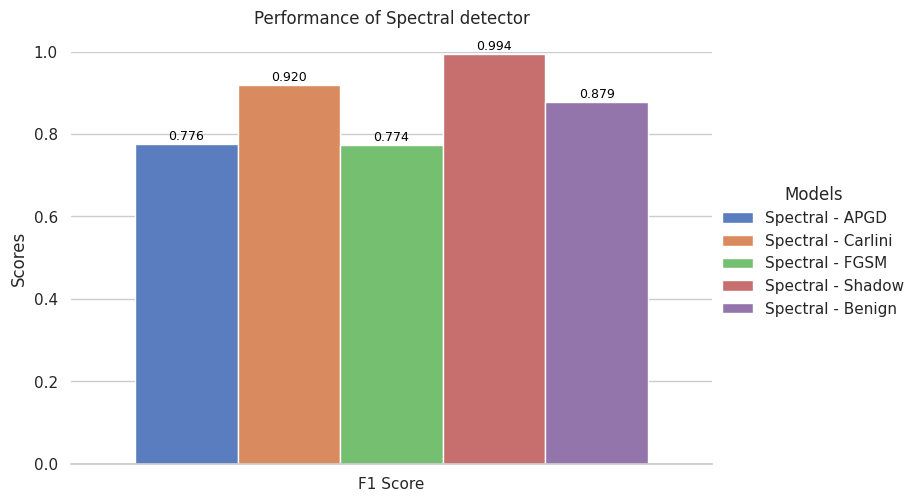

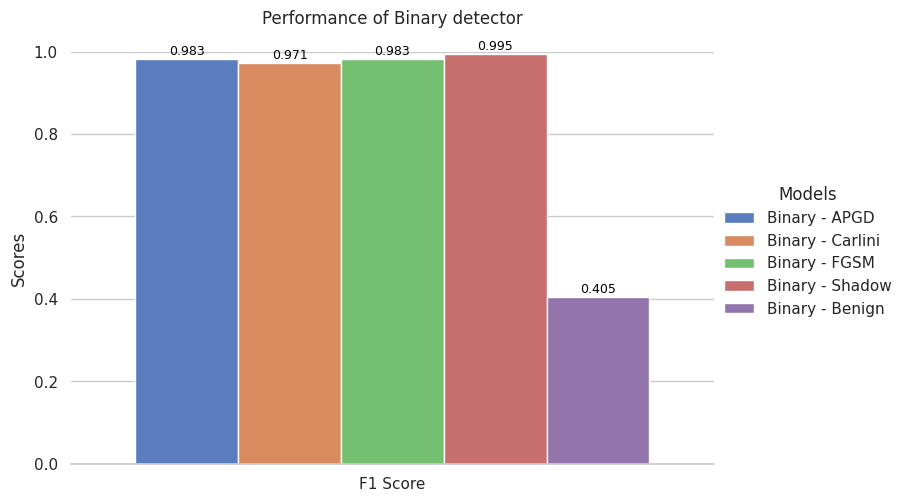

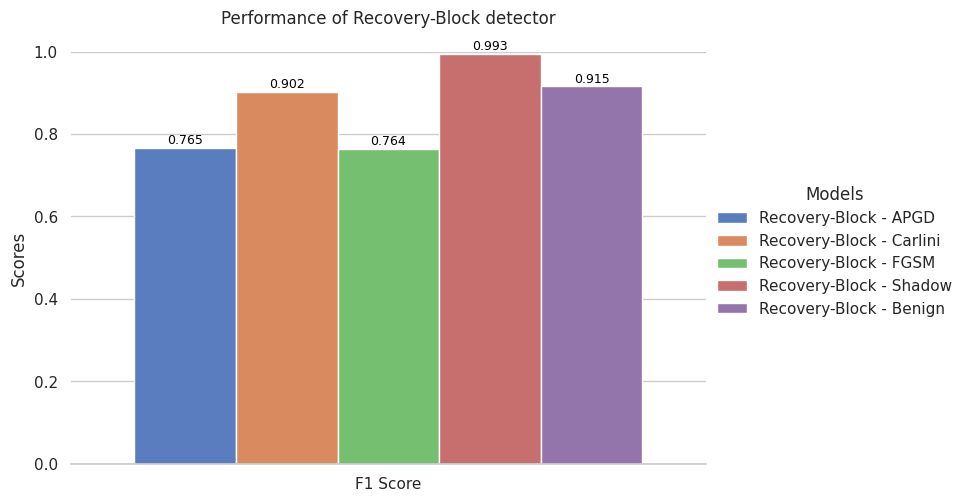

In [10]:

def plot_metrics_nvp_list_metrics(metrics_combined, Bar_str, should_save=False):
    bar_labels = [Bar_str]
    
    merged_metrics = [metrics_combined]

    data = []
    for metric_key in merged_metrics[0].keys():
        for i, d in enumerate(merged_metrics):
            f1_score = d[metric_key]['f1_score']
            data.append({'Models': f'{bar_labels[i]} - {metric_key}', 'Metric': 'F1 Score', 'Value': f1_score})

    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    g = sns.catplot(x="Metric", y="Value", hue="Models", data=df, kind="bar", palette="muted", height=5, aspect=1.5)
    g.despine(left=True)
    g.set_ylabels("Scores")
    plt.title(f'Performance of {Bar_str} detector', pad=20)
    g.set_xlabels("")

    g.axes.flat[0].set_ylim([0.0,1])

    for ax in g.axes.flat:
        for label in ax.containers:
            for p, rect in zip(label.patches, label.get_children()):
                ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 3), textcoords='offset points')
    if should_save:
        plt.savefig(
            f"{project_root}/plots/recovery_attack_type_performance_{Bar_str}_f1_roc.svg",  bbox_inches = 'tight'
        )
        plt.savefig(
            f"{project_root}/plots/recovery_attack_type_performance_{Bar_str}_f1_roc.png",  bbox_inches = 'tight'
        )
    plt.show()

spectral_metrics = calculate_pred_list_metrics(s_preds, spectral_threshold)
binary_metrics = calculate_pred_list_metrics(b_preds, binary_threshold)
combined_metrics = calculate_pred_list_metrics_recovery(recovery_block_preds, rb_spectral_threshold, rb_binary_threshold)


plot_metrics_nvp_list_metrics(spectral_metrics,"Spectral", should_save=True)
plot_metrics_nvp_list_metrics(binary_metrics,"Binary", should_save=True)
plot_metrics_nvp_list_metrics(combined_metrics,"Recovery-Block", should_save=True)

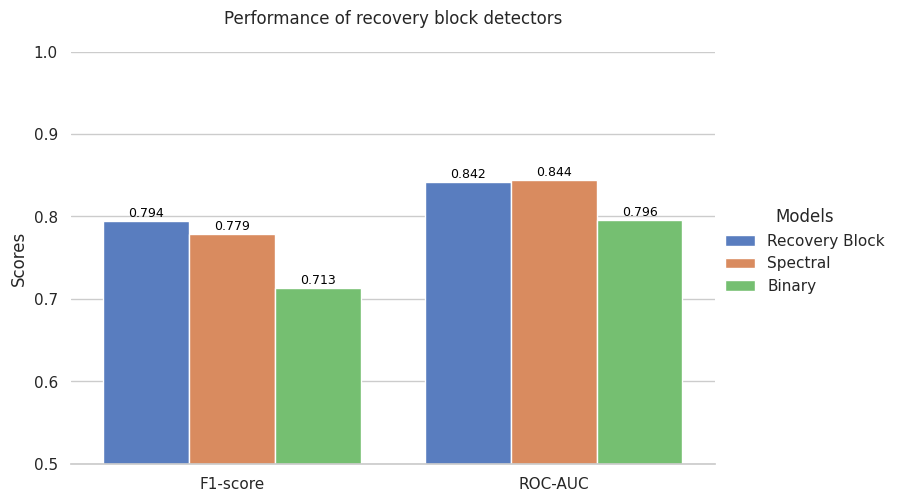

In [11]:


def plot_metrics_seaborn_enhanced_f1_roc(report_combined, report_sad, report_binary, should_save=False):
    combined_metrics = calculate_metrics(report_combined)
    sad_metrics = calculate_metrics(report_sad)
    binary_metrics = calculate_metrics(report_binary)

    bar_labels = ["Recovery Block","Spectral","Binary",]
    merged_metrics = [combined_metrics, sad_metrics, binary_metrics]

    
    f1_scores = [d['combined']['f1_score'] for d in merged_metrics]
    roc_aucs = [d['combined']['roc_auc'] for d in merged_metrics]

    data = []
    for i, (f1_score, roc_auc) in enumerate(zip(f1_scores, roc_aucs)):
        data.append({'Models': f'{bar_labels[i]}', 'Metric': 'F1-score', 'Value': f1_score})
        data.append({'Models': f'{bar_labels[i]}', 'Metric': 'ROC-AUC', 'Value': roc_auc})
    
    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    g = sns.catplot(x="Metric", y="Value", hue="Models", data=df, kind="bar", palette="muted", height=5, aspect=1.5)
    g.despine(left=True)
    g.set_ylabels("Scores")
    plt.title(f'Performance of recovery block detectors', pad=20)
    g.set_xlabels("")
    
    g.axes.flat[0].set_ylim([0.5,1])

    for ax in g.axes.flat:
        for label in ax.containers:
            for p, rect in zip(label.patches, label.get_children()):
                ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 3), textcoords='offset points')
    if should_save:
        plt.savefig(
            f"{project_root}/plots/recovery_performance_enhanced_f1_roc.png",  bbox_inches = 'tight'
        )
        plt.savefig(
            f"{project_root}/plots/recovery_performance_enhanced_f1_roc.svg",  bbox_inches = 'tight'
        )
    plt.show()
plot_metrics_seaborn_enhanced_f1_roc(report_recovery, report_benchmark_spectral, report_benchmark_binary, should_save=True)

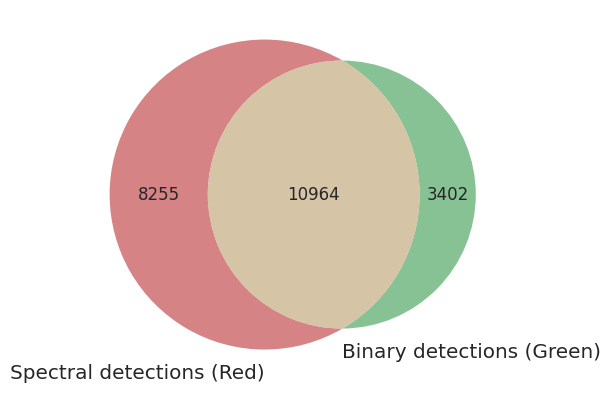

In [12]:


def calculate_overlap(sad_predictions,binary_predictions,threshold1, threshold2, should_save=None):

    
    detected_1 = []
    detected_2 = []
    # Iterate over the list
    for i, (s, b) in enumerate(zip(sad_predictions,binary_predictions)):

        # Increment counters
        if (s[0] >= threshold1 and s[1] == 1) or (s[0] <= threshold1 and s[1] == 0):
            detected_1.append(i)
        if (b[0] >= threshold2 and b[1] == 1) or (b[0] <= threshold2 and b[1] == 0):
            detected_2.append(i)

    
    venn2([set(detected_1), set(detected_2)], set_labels = ('Spectral detections (Red)', 'Binary detections (Green)'),alpha=0.7)
    
    if should_save is not None:
        plt.savefig(
            f"{project_root}/plots/recovery_spectral_binary_overlap.png", bbox_inches = 'tight'
        )
        plt.savefig(
            f"{project_root}/plots/recovery_spectral_binary_overlap.svg", bbox_inches = 'tight'
        )
    plt.show()  
    

calculate_overlap(s_preds,b_preds, rb_spectral_threshold, rb_binary_threshold, should_save=True)
